In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from fbprophet import Prophet
import altair as alt
import glob 
from scipy import stats
from sklearn.preprocessing import LabelEncoder
alt.renderers.enable('notebook')
pd.options.mode.chained_assignment = None  # default='warn'

annotations_in_temp = "data/annotations/s{}.csv"
tobii_in_temp = "data/tobii/s{}.csv"
subject_cards_file = "data/cards.csv"

features_baseline_sub_out = "features/features_sub_noout.csv"
features_baseline_div_out = "features/features_div_noout.csv"
features_baseline_none_out = "features/features_none_noout.csv"

#annotations_in_temp = "data/PILOT/annotations/s{}.txt"
#tobii_in_temp = "data/PILOT/tobii/s{}.csv"
#subject_cards_file = "data/PILOT/cards.csv"

#features_baseline_sub_out = "features/PILOT/features_sub_noout.csv"
#features_baseline_div_out = "features/PILOT/features_div.csv"
#features_baseline_none_out = "features/PILOT/features_none.csv"

figures_out = "data/figures/ts/{}.jpg"


In [2]:
def clearFloats(x):
    if(type(x) == str):
        x = x.replace('\U00002013', '-').replace(',', '.')
    return x   

In [3]:
def preprocessEye(eye_file):
    # read the eye file
    
    df = pd.read_csv(eye_file, encoding='utf-16', sep='\t')
    
    # rename columns
    df.columns = ['timestamp','prj_name','exp_date','name','rec_name','rec_date','start_time','duration',
                  'rec_fix_filter_name','event','event_val','gaze_x','gaze_y','gaze_3d_x','gaze_3d_y','gaze_3d_z',
                  'gaze_dir_right_x','gaze_dir_right_y','gaze_dir_right_z','gaze_dir_left_x','gaze_dir_left_y',
                  'gaze_dir_left_z','pupil_pos_left_x','pupil_pos_left_y','pupil_pos_left_y',
                  'pupil_pos_right_x','pupil_pos_right_y','pupil_pos_right_z',
                  'diam_left', 'diam_right',
                  'rec_media_name', 'rec_media_width', 'rec_media_heigh',
                  'move_type','event_dur','move_type_id','fix_x','fix_y',
                  'gyro_x','gyro_y', 'gyro_z','acc_x', 'acc_y', 'acc_z',
                  'ID']
        
    # remove useless columns
    df = df.drop(['ID','prj_name','exp_date', 'rec_name', 'duration',
                  'rec_fix_filter_name','gaze_x','gaze_y','gaze_3d_x','gaze_3d_y','gaze_3d_z',
                  'gaze_dir_right_x','gaze_dir_right_y','gaze_dir_right_z','gaze_dir_left_x','gaze_dir_left_y',
                  'gaze_dir_left_z','pupil_pos_left_x','pupil_pos_left_y','pupil_pos_left_y',
                  'pupil_pos_right_x','pupil_pos_right_y','pupil_pos_right_z',
                  'rec_media_name', 'rec_media_width', 'rec_media_heigh',
                  'gyro_x','gyro_y', 'gyro_z','acc_x', 'acc_y', 'acc_z'
                 ], axis=1)
    
    # remove useless events
    df = df[df.move_type != "EyesNotFound"]
    df = df[df.event != "RecordingStart"]
    df = df[df.event != "RecordingEnd"]
    df = df[df.event != "SyncPortOutHigh"]
    df = df[df.event != "SyncPortOutLow"]
    df = df.drop(['event', 'event_val'], axis=1)
    
    # set datatypes
    df = df.applymap(clearFloats)
    dfe = df.apply(pd.to_numeric, errors='ignore')
    
    #dfe['dt_index'] = pd.to_datetime(dfe['rec_date'] + ' ' + dfe['start_time'], \
    #                                 format="%d/%m/%Y %H:%M:%S.%f") + \
    #                                pd.to_timedelta(dfe['timestamp'], unit='ms')
    
    dfe['dt_index'] = pd.to_datetime(dfe['start_time'], \
                                     format="%H:%M:%S.%f") + \
                                    pd.to_timedelta(dfe['timestamp'], unit='ms')
    
    dfe = dfe.set_index(pd.DatetimeIndex(dfe['dt_index']))    
    return dfe

In [4]:
def preprocessAnnotations(annotation_file, card_names):
    # read the eye file
    annot = pd.read_csv(annotation_file, sep='\t', names=['tire', 'remove', 'start', 'stop', 'duration', 'class'])
    annot = annot.drop(['remove'], axis=1)
    annot['show_order'] = annot.index
    
    annot['start_ms'] = annot['start'].apply(stringToMSec)
    annot['stop_ms'] = annot['stop'].apply(stringToMSec)
    annot['duration_ms'] = annot['duration'].apply(stringToMSec)
    annot = annot.drop(['start', 'stop', 'duration'], axis=1)
    default = annot.loc[annot['tire'] == "default"]
    
    dfs = [default]
    
    for card in card_names:
        dfs.append(
            annot.loc[(annot['tire'] == "per_card") & (annot['class'] == card)]
        )
        
    return dfs

In [5]:
def stringToMSec(time):
    h, m, sms = time.split(':')
    s, ms = sms.split('.')
    return 1000 * (int(h)*3600 + int(m)*60 + int(s)) + int(ms)

def normalize(df, column):
    max_value = df[column].max()
    min_value = df[column].min()
    df.loc[:, column] = (df[column] - min_value) / (max_value - min_value)
    
    return df


In [6]:
def cleanTimeSeries(ts):
    # Filter Outliers in Pupil Dilation
    righ_mean = ts["diam_right"].mean(skipna = True)
    righ_std = ts["diam_right"].std(skipna = True)
    left_mean = ts["diam_left"].mean(skipna = True)
    left_std = ts["diam_left"].std(skipna = True)
    
    #Filter Outliers
    treshold = 5
    
    ts.loc[(np.abs((ts["diam_right"] - righ_mean) / righ_std) >= treshold), 'diam_right'] = np.NaN
    ts.loc[(np.abs((ts["diam_left"] - left_mean) / left_std) >= treshold), 'diam_left'] = np.NaN
    return ts

def resampleAndFill(ts):
    # RESAMPLE
    ts['diam_right'] = ts[['diam_right']].resample("ms").mean()
    ts['diam_left'] = ts[['diam_left']].resample("ms").mean()   
    
    # Fill NaN
    ts["diam_right"] = ts[["diam_right"]].fillna(method="ffill")
    ts["diam_left"] = ts[["diam_left"]].fillna(method="ffill")
 
    # Smooth    
    ts["diam_right"] = ts[['diam_right']].rolling(window=150).mean()
    ts["diam_left"] = ts[['diam_left']].rolling(window=150).mean() 

    return ts

def filterEyeData(eyeDF, annot):
    annot = annot.reset_index()
    start = annot.at[0, 'start_ms']
    stop = annot.at[0, 'stop_ms']
    novelty = eyeDF.loc[(eyeDF['timestamp'] >= start) & (eyeDF['timestamp'] <= stop)]
    novelty = cleanTimeSeries(novelty)
    #novelty = resampleAndFill(novelty) 
    
    return novelty


def filterShortEyeResponse(eyeDF, annot, after_start=True, before_end=False, ms=1500):
    annot = annot.reset_index()
    start = annot.at[0, 'start_ms']
    stop = annot.at[0, 'stop_ms']    
    
    if(after_start and not before_end):
        # After Start
        short_stop = start + ms #look to a window of 1.5 seconds after the stimulus    
        stop = min(short_stop, stop)    
        
    elif(before_end and not after_start):
        # Before End
        short_start = stop - ms
        start = max(short_start, start)
        
    else:
        # Balanced Window
        
        short_stop = start + ms #look to a window of 1.5 seconds after the stimulus    
        stop = min(short_stop, stop)
        
        short_start = stop - ms
        start = max(short_start, start)
        
    
    short_response = eyeDF.loc[(eyeDF['timestamp'] >= start) & (eyeDF['timestamp'] <= stop)]
    
    #short_response = cleanTimeSeries(short_response) 
    return short_response

def filterBaseline(eyeDF, annot, ms_before=1500):
    annot = annot.reset_index()
    start = annot.at[0, 'start_ms']
    stop = annot.at[0, 'start_ms']
    
    early_start = start - ms_before #look to a window of 1.5 seconds before the overall stimulus
    baseline = eyeDF.loc[(eyeDF['timestamp'] >= early_start) & (eyeDF['timestamp'] <= stop)]
    
    #baseline = cleanTimeSeries(baseline) 
    return baseline


In [7]:
def loadTimeSeries(subject, card_names,
                   tobbi_input_template=tobii_in_temp,
                   annot_input_template=annotations_in_temp,
                   short_response_dur=1500):
    
    print("LOAD s{}".format(subject))
    
    f_in = tobbi_input_template.format(subject)
    annot_in = annot_input_template.format(subject)
    
    # vector with temporal filtered data for each card
    cards = []
    cards_sr_early = []
    cards_sr_late = []
    
    # load tobii data
    eye = preprocessEye(f_in.format(subject))
    
    # load novelty annotations
    annotations = preprocessAnnotations(
        annot_in.format(subject), card_names)
    
    # filter eye data relative to overall novelty phase
    overall = filterEyeData(eye, annotations[0])
    
    # filter the baseline to rescale the pupil dilation data
    baseline = filterBaseline(eye, annotations[0], ms_before=5000)
    
    # single cards eye data overall and in the 1.5 sec after the stimulus
    for i in range(1, len(annotations)):
        c = filterEyeData(eye, annotations[i])
        
        early = filterShortEyeResponse(overall,
                                         annotations[i],
                                         after_start=True,
                                         before_end=False,
                                         ms=short_response_dur)
        
        late = filterShortEyeResponse(overall,
                                         annotations[i],
                                         after_start=False,
                                         before_end=True,
                                         ms=short_response_dur)
        
        c['class'] = annotations[i]['class'].iloc[0]
        cards.append(c)
        cards_sr_early.append(early)
        cards_sr_late.append(late)
    
    return eye, annotations, baseline, overall, cards, cards_sr_early, cards_sr_late

In [8]:
def getSubjectCard(subject, cards_file=subject_cards_file):
    s_cards = pd.read_csv(cards_file, sep=';')
    sub_name = "s" + str(subject)    
    card = s_cards.loc[s_cards['subject'] == sub_name]
    return card['card'].values[0]

def plotPupilDilationTimeSeries(subject, card_names, overall_eye, cards_eye,
                                subj_card_in=subject_cards_file):
    
    colors = ['green', 'yellow', 'red', 'purple', 'grey', 'pink']
    cards_plot_features = []
    
    for i in range(0, len(cards_eye)):    
        cards_plot_features.append([
            cards_eye[i]['timestamp'].min(),
            cards_eye[i]['timestamp'].max(),
            card_names[i]
        ])    
        
    cards_plot_features.sort()    
    sub_card = getSubjectCard(subject, subj_card_in)
    
    fig, ass = plt.subplots(3, figsize=(15, 15))
    
    ass[0].set_title("RIGHT {}".format(subject))
    ass[1].set_title("LEFT {}".format(subject))
    #ass[2].set_title("BOTH")
    
    ass[0].scatter(overall_eye['timestamp'],overall_eye['diam_right'], s=2, c='r')
    ass[1].scatter(overall_eye['timestamp'],overall_eye['diam_left'], s=2, c='b')
    ass[2] = overall_eye['diam_right'].plot(kind="density", linewidth=2, color="r")
    ass[2] = overall_eye['diam_left'].plot(kind="density", linewidth=2, color="b")
        
    
    #ass[0].plot(rolling_right, c='black')
    #ass[1].plot(rolling_left, c='red')
    #ass[2].plot(overall_eye['diam_right'])
    #ass[2].plot(overall_eye['diam_left'])

    for i in range(0, len(cards_eye)):    
        alp = 0.2
        color = 'green'
        if(cards_plot_features[i][2] == sub_card):
            alp = 0.3
            color = 'yellow'
            
        ass[0].axvspan(cards_plot_features[i][0],
                       cards_plot_features[i][1],
                       linewidth=1, color=color, alpha=alp)
        
        ass[1].axvspan(cards_plot_features[i][0],
                       cards_plot_features[i][1],
                       linewidth=1, color=color, alpha=alp)
        
        #ass[2].axvspan(cards_plot_features[i][0],
        #               cards_plot_features[i][1],
        #               linewidth=1, color=color, alpha=alp)
    
    #plt.show()    
    return fig

In [9]:
subject = 5
eye = preprocessEye(tobii_in_temp.format(subject))

# load novelty annotations
annotations = preprocessAnnotations(
        annotations_in_temp.format(subject), card_names)

# filter eye data relative to overall novelty phase
overall = filterEyeData(eye, annotations[0])

NameError: name 'card_names' is not defined

LOAD s25
unicorn


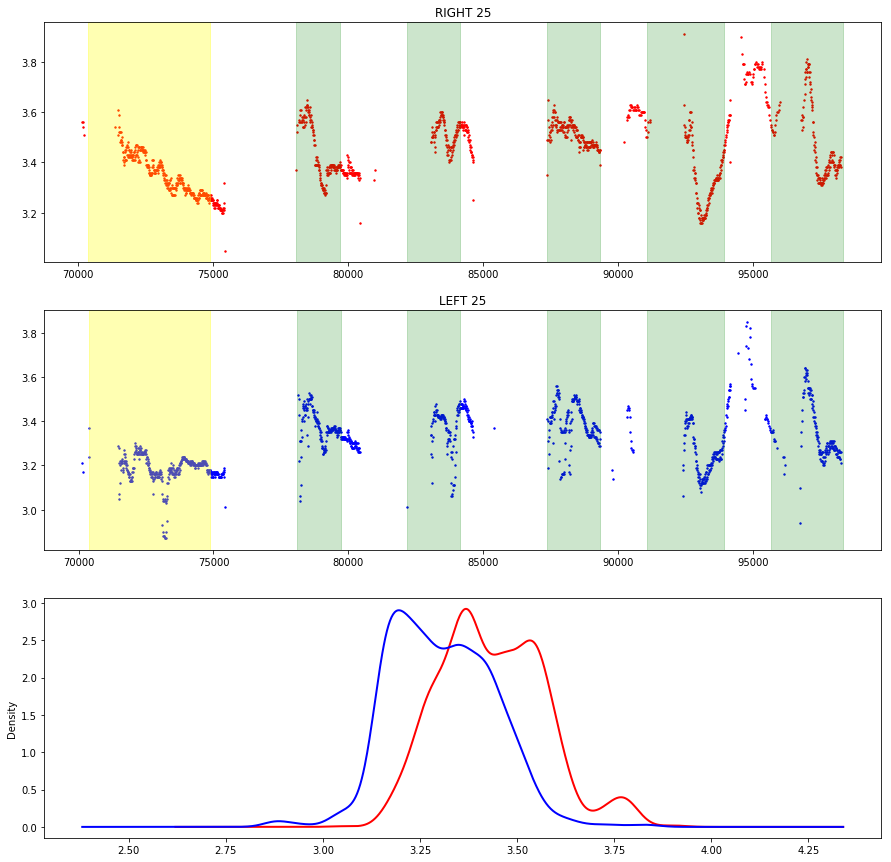

In [10]:
subject = 25
card_names = ['unicorn', 'pepper', 'minion', 'pig', 'hedge', 'aliens']

eye_df, annot_dfs, baseline, overall_eye_df, cards_eye_dfs, early_sr, late_sr = \
                                                                    loadTimeSeries(subject, card_names)

subject_card = getSubjectCard(subject, subject_cards_file)
fig = plotPupilDilationTimeSeries(subject, card_names, overall_eye_df, cards_eye_dfs)
print(subject_card)

In [ ]:
class SubjectMagicFeatures:
    
    def __init__(self,
                 subject,
                 subject_card,
                 annot_dfs,
                 card_eye_dfs,
                 card_eye_sr_early_dfs,
                 card_eye_sr_late_dfs,
                 short_resp_duration_ms,
                 cols,
                 refer_to_baseline=False,
                 baseline=None,
                 refer_method='sub'):
        
        # ==== CALCULATE THE BASELINE =============
        if(refer_to_baseline):            
            self.base_right_mean = baseline['diam_right'].mean(skipna = True)
            self.base_left_mean = baseline['diam_left'].mean(skipna = True)     
            
        self.features = pd.DataFrame(columns=cols)
        
        # Process Each card and compose the dataframe
        for c in range(0, len(card_eye_dfs)):
                   
            # ==== TASK FEATURES =============
            
            self.subject = subject
            self.duration = annot_dfs[c+1]['duration_ms'].iloc[0]
            self.card_class = cards_eye_dfs[c]['class'].iloc[0]
            
            if(self.card_class == subject_card):
                self.is_subject_one = 1
            else:
                self.is_subject_one = 0
                
            self.show_order = annot_dfs[c+1]['show_order'].iloc[0]        
        
            # ==== EXTRACT CARD ==========
            
            card = cards_eye_dfs[c][['diam_right', 'diam_left', 'move_type']]
            sr_early_card = card_eye_sr_early_dfs[c][['diam_right', 'diam_left', 'move_type']]      
            sr_late_card = card_eye_sr_late_dfs[c][['diam_right', 'diam_left', 'move_type']]  
        
            # ==== EVENTS =============
            
            move_types = card[['move_type']]
            move_types['count'] = 1
            move_types = move_types.groupby('move_type').count()
            
            fix_num = move_types.loc[move_types.index == "Fixation"]
            sacc_num = move_types.loc[move_types.index == "Saccade"]
            
            # Check if not empty
            if not fix_num.empty:
                fix_num = fix_num.iloc[0][0]
            else:
                fix_num = 0
                
            if not sacc_num.empty:
                sacc_num = sacc_num.iloc[0][0]
            else:
                sacc_num = 0
            
            #fix_num = move_types.loc[move_types.index == "Fixation"].iloc[0][0]
            #sacc_num = move_types.loc[move_types.index == "Saccade"].iloc[0][0]
            
            duration_sec = self.duration / 1000
            
            self.fix_freq = fix_num / duration_sec
            self.sacc_freq = sacc_num / duration_sec
            
            # ==== EVENTS SHORT RESPONSE EARLY =============
            
            sre_move_types = sr_early_card[['move_type']]
            sre_move_types['count'] = 1
            sre_move_types = sre_move_types.groupby('move_type').count()
            
            sre_fix_num = move_types.loc[sre_move_types.index == "Fixation"]
            sre_sacc_num = move_types.loc[sre_move_types.index == "Saccade"]
            
            # Check if not empty
            if not sre_fix_num.empty:
                sre_fix_num = sre_fix_num.iloc[0][0]
            else:
                sre_fix_num = 0
                
            if not sre_sacc_num.empty:
                sre_sacc_num = sre_sacc_num.iloc[0][0]
            else:
                sre_sacc_num = 0
            
            sr_duration_sec = short_resp_duration_ms / 1000
            
            self.sre_fix_freq = sre_fix_num / sr_duration_sec
            self.sre_sacc_freq = sre_sacc_num / sr_duration_sec
            
            # ==== EVENTS SHORT RESPONSE LATE =============
            
            srl_move_types = sr_late_card[['move_type']]
            srl_move_types['count'] = 1
            srl_move_types = srl_move_types.groupby('move_type').count()
            
            srl_fix_num = move_types.loc[srl_move_types.index == "Fixation"]
            srl_sacc_num = move_types.loc[srl_move_types.index == "Saccade"]
            
            # Check if not empty
            if not srl_fix_num.empty:
                srl_fix_num = srl_fix_num.iloc[0][0]
            else:
                srl_fix_num = 0
                
            if not srl_sacc_num.empty:
                srl_sacc_num = srl_sacc_num.iloc[0][0]
            else:
                srl_sacc_num = 0
            
            self.srl_fix_freq = srl_fix_num / sr_duration_sec
            self.srl_sacc_freq = srl_sacc_num / sr_duration_sec

            # ==== RESCALE DATA TO BASELINE =============
            
            if(refer_to_baseline):
                if(refer_method == 'sub'):
                    card['diam_right'] = card['diam_right'] - self.base_right_mean
                    card['diam_left'] = card['diam_left'] - self.base_left_mean
                    
                if(refer_method == 'div'):
                    card['diam_right'] = card['diam_right'] / self.base_right_mean
                    card['diam_left'] = card['diam_left'] / self.base_left_mean
                
            # ==== SINGLE CARD PUPIL FEATURES =============
           
            # RIGHT PUPIL
            self.pupil_diam_right_mean = card['diam_right'].mean(skipna = True)
            self.pupil_diam_right_std = card['diam_right'].std(skipna = True)
            self.pupil_diam_right_min = card['diam_right'].min(skipna = True)
            self.pupil_diam_right_max = card['diam_right'].max(skipna = True)
            
            # LEFT PUPIL            
            self.pupil_diam_left_mean = card['diam_left'].mean(skipna = True)
            self.pupil_diam_left_std = card['diam_left'].std(skipna = True)
            self.pupil_diam_left_min = card['diam_left'].min(skipna = True)
            self.pupil_diam_left_max = card['diam_left'].max(skipna = True)

            # ==== SINGLE CARD EARLY SHORT RESPONSE PUPIL FEATURES =============
            
            # RIGHT PUPIL
            self.sre_pupil_diam_right_mean = sr_early_card['diam_right'].mean(skipna = True)
            self.sre_pupil_diam_right_std = sr_early_card['diam_right'].std(skipna = True)
            self.sre_pupil_diam_right_min = sr_early_card['diam_right'].min(skipna = True)
            self.sre_pupil_diam_right_max = sr_early_card['diam_right'].max(skipna = True)
            
            # LEFT PUPIL            
            self.sre_pupil_diam_left_mean = sr_early_card['diam_left'].mean(skipna = True)
            self.sre_pupil_diam_left_std = sr_early_card['diam_left'].std(skipna = True)
            self.sre_pupil_diam_left_min = sr_early_card['diam_left'].min(skipna = True)
            self.sre_pupil_diam_left_max = sr_early_card['diam_left'].max(skipna = True)
            
            # ==== SINGLE CARD LATE SHORT RESPONSE PUPIL FEATURES =============
            
            # RIGHT PUPIL
            self.srl_pupil_diam_right_mean = sr_late_card['diam_right'].mean(skipna = True)
            self.srl_pupil_diam_right_std = sr_late_card['diam_right'].std(skipna = True)
            self.srl_pupil_diam_right_min = sr_late_card['diam_right'].min(skipna = True)
            self.srl_pupil_diam_right_max = sr_late_card['diam_right'].max(skipna = True)
            
            # LEFT PUPIL            
            self.srl_pupil_diam_left_mean = sr_late_card['diam_left'].mean(skipna = True)
            self.srl_pupil_diam_left_std = sr_late_card['diam_left'].std(skipna = True)
            self.srl_pupil_diam_left_min = sr_late_card['diam_left'].min(skipna = True)
            self.srl_pupil_diam_left_max = sr_late_card['diam_left'].max(skipna = True)

            self.column_names = cols            
            self.features = self.features.append(self.aggregate(), ignore_index=True)

    def getDataFrame(self):
        return self.features
    
    def aggregate(self):
        return pd.DataFrame(
            data=[[
                self.subject,
                self.duration,
                self.card_class,
                self.show_order,
                self.fix_freq,
                self.sacc_freq,
                self.pupil_diam_right_mean,
                self.pupil_diam_right_std,
                self.pupil_diam_right_min,
                self.pupil_diam_right_max,
                self.pupil_diam_left_mean,
                self.pupil_diam_left_std,
                self.pupil_diam_left_min,
                self.pupil_diam_left_max,
                self.sre_fix_freq,
                self.sre_sacc_freq,
                self.sre_pupil_diam_right_mean,
                self.sre_pupil_diam_right_std,
                self.sre_pupil_diam_right_min,
                self.sre_pupil_diam_right_max,
                self.sre_pupil_diam_left_mean,
                self.sre_pupil_diam_left_std,
                self.sre_pupil_diam_left_min,
                self.sre_pupil_diam_left_max,
                self.srl_fix_freq,
                self.srl_sacc_freq,
                self.srl_pupil_diam_right_mean,
                self.srl_pupil_diam_right_std,
                self.srl_pupil_diam_right_min,
                self.srl_pupil_diam_right_max,
                self.srl_pupil_diam_left_mean,
                self.srl_pupil_diam_left_std,
                self.srl_pupil_diam_left_min,
                self.srl_pupil_diam_left_max,
                self.is_subject_one,
            ]],
            columns=self.column_names
        )        

In [503]:
def extractMinSubjectSet(path):
    filenames = glob.glob(path.format("*"))
    
    subjects = []
    
    for fn in filenames:
        id =fn.split("/")[-1].split(".")[0].replace('s', '')
        subjects.append(int(id))
    
    return subjects

annot_subs = extractMinSubjectSet(annotations_in_temp)
eye_subs = extractMinSubjectSet(tobii_in_temp)

annot_subs

[11, 5, 9, 15, 12, 10, 8, 6]

LOAD s5
LOAD s6
LOAD s8
LOAD s9
LOAD s10
LOAD s11
LOAD s12


/home/dario/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: DtypeWarning:

Columns (13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.



LOAD s15


/home/dario/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3296: DtypeWarning:

Columns (13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29) have mixed types. Specify dtype option on import or set low_memory=False.



,subject,duration,card_class,show_order,fix_freq,sacc_freq,pupil_diam_right_mean,pupil_diam_right_std,pupil_diam_right_min,pupil_diam_right_max,...,srl_pupil_diam_right_mean,srl_pupil_diam_right_std,srl_pupil_diam_right_min,srl_pupil_diam_right_max,srl_pupil_diam_left_mean,srl_pupil_diam_left_std,srl_pupil_diam_left_min,srl_pupil_diam_left_max,label,card_class_enc
0,5,6149,unicorn,1,47.812652,5.691982,-0.094038,0.237862,-0.420840,0.509160,...,3.116133,0.061892,3.00,3.22,3.445067,0.057015,3.33,3.54,0,5
1,5,3930,pepper,2,48.346056,7.379135,0.008639,0.080180,-0.230840,0.139160,...,3.457023,0.049640,3.25,3.56,3.785191,0.061474,3.55,3.89,1,3
2,5,3559,minion,3,37.651026,5.338578,-0.338045,0.125301,-0.480840,-0.080840,...,3.090333,0.126313,2.94,3.34,3.345467,0.137692,3.12,3.63,0,2
3,5,5599,pig,6,41.078764,3.750670,-0.132066,0.044406,-0.180840,-0.000840,...,3.225000,0.034733,3.16,3.30,3.516600,0.057636,3.30,3.61,0,4
4,5,4219,hedge,4,54.989334,4.977483,-0.232918,0.132704,-0.410840,0.119160,...,3.100464,0.051850,3.01,3.23,3.360464,0.060634,3.24,3.52,0,1
5,5,3880,aliens,5,59.278351,4.381443,-0.238532,0.149171,-0.540840,0.049160,...,3.106667,0.107277,2.88,3.35,3.367133,0.130345,3.09,3.71,0,0
6,6,4507,unicorn,5,0.000000,0.000000,-0.341786,0.083634,-0.574569,-0.204569,...,2.965205,0.034605,2.91,3.02,2.639041,0.067724,2.40,2.73,0,5
7,6,3939,pepper,2,30.464585,4.061945,-0.342144,0.042868,-0.484569,-0.304569,...,3.025200,0.032105,2.98,3.08,2.683733,0.057393,2.52,2.76,0,3
8,6,4069,minion,3,27.279430,3.440649,-0.331680,0.107114,-0.604569,-0.174569,...,2.981467,0.031652,2.91,3.06,2.653200,0.045594,2.51,2.76,0,2
9,6,3750,pig,6,0.000000,0.000000,-0.245531,0.116130,-0.504569,-0.104569,...,3.086533,0.027631,3.05,3.14,2.747200,0.037617,2.61,2.80,1,4


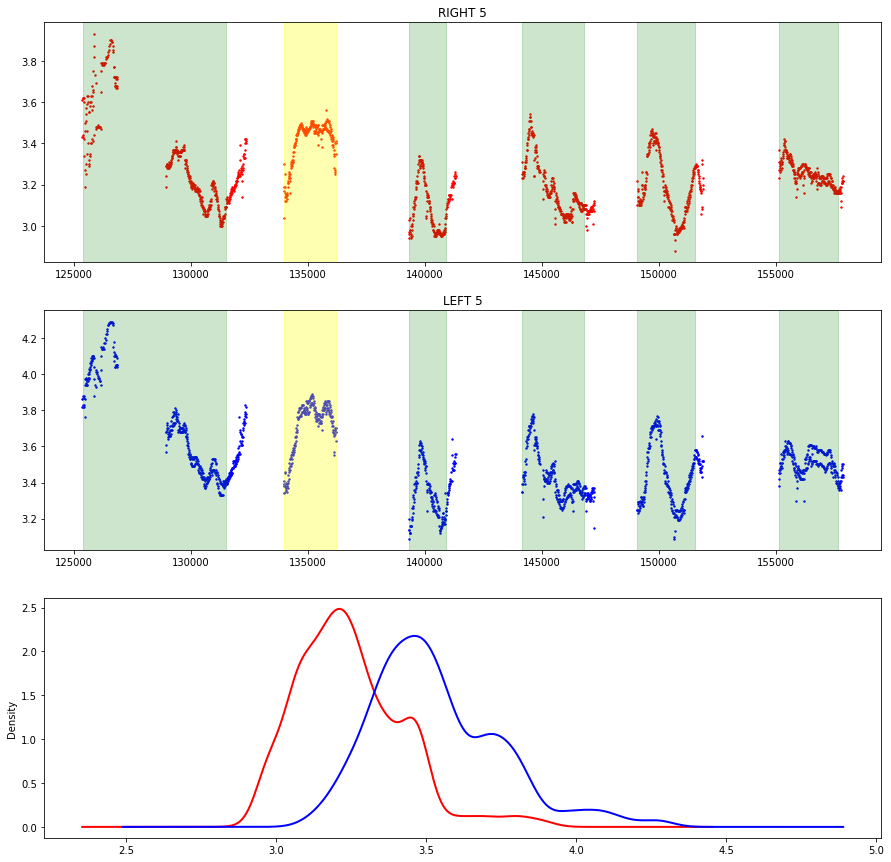

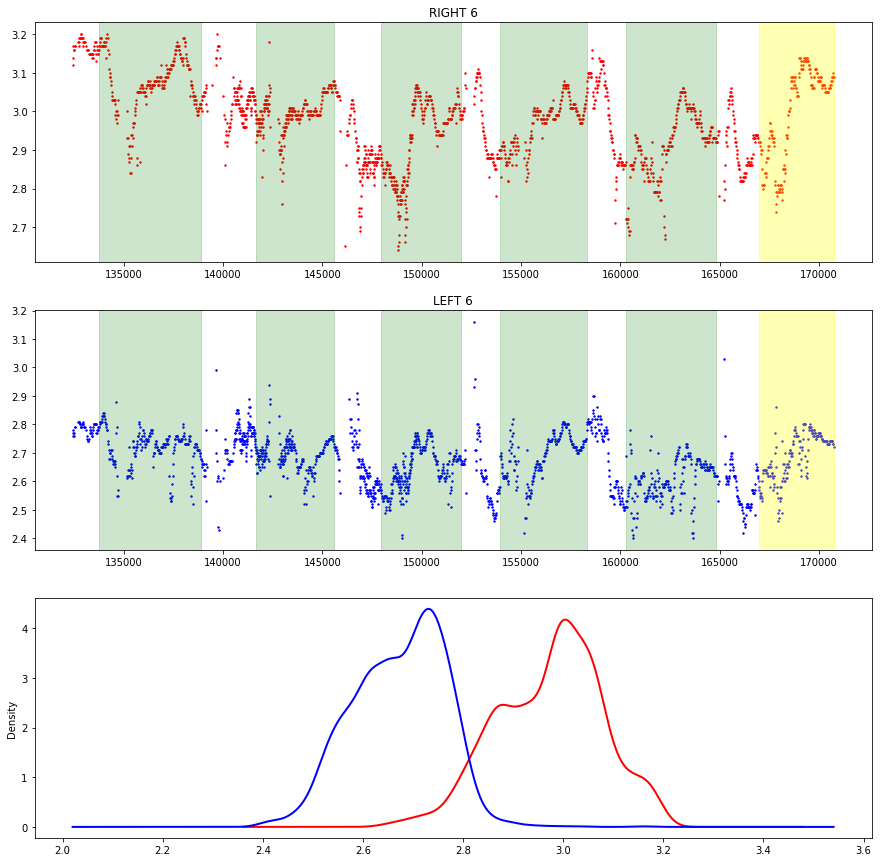

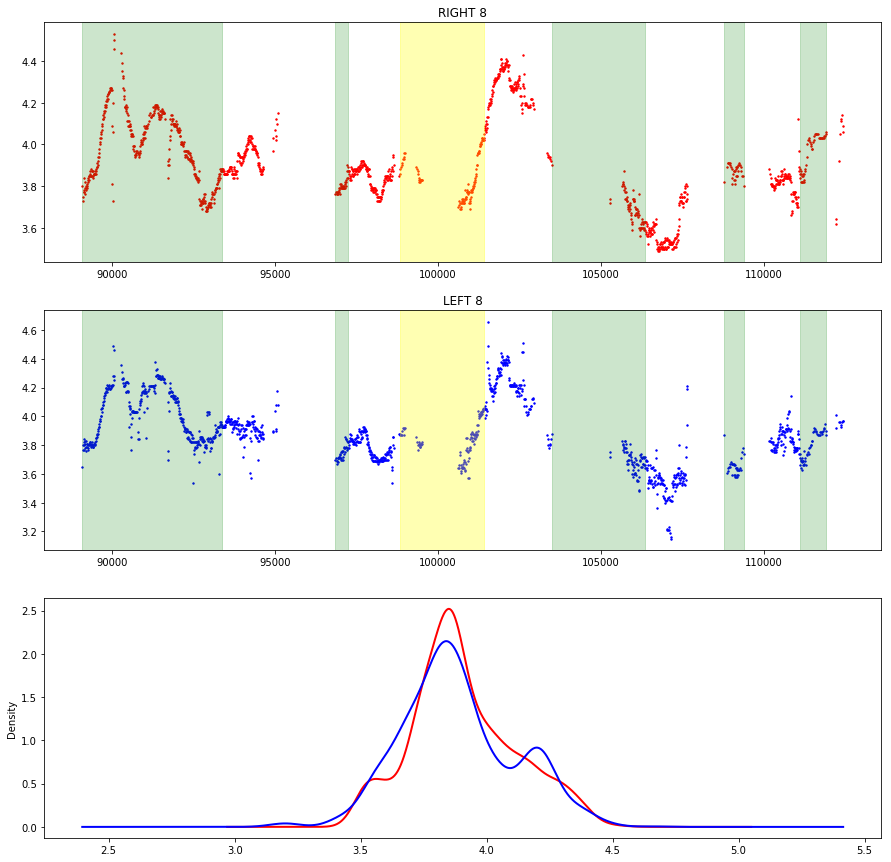

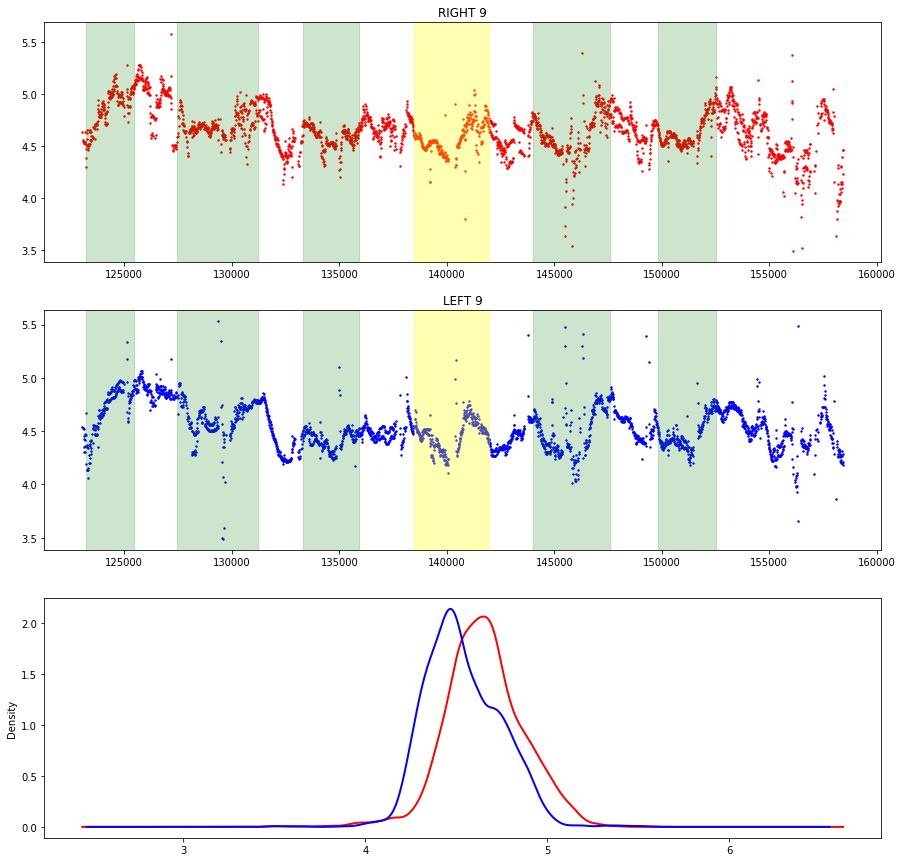

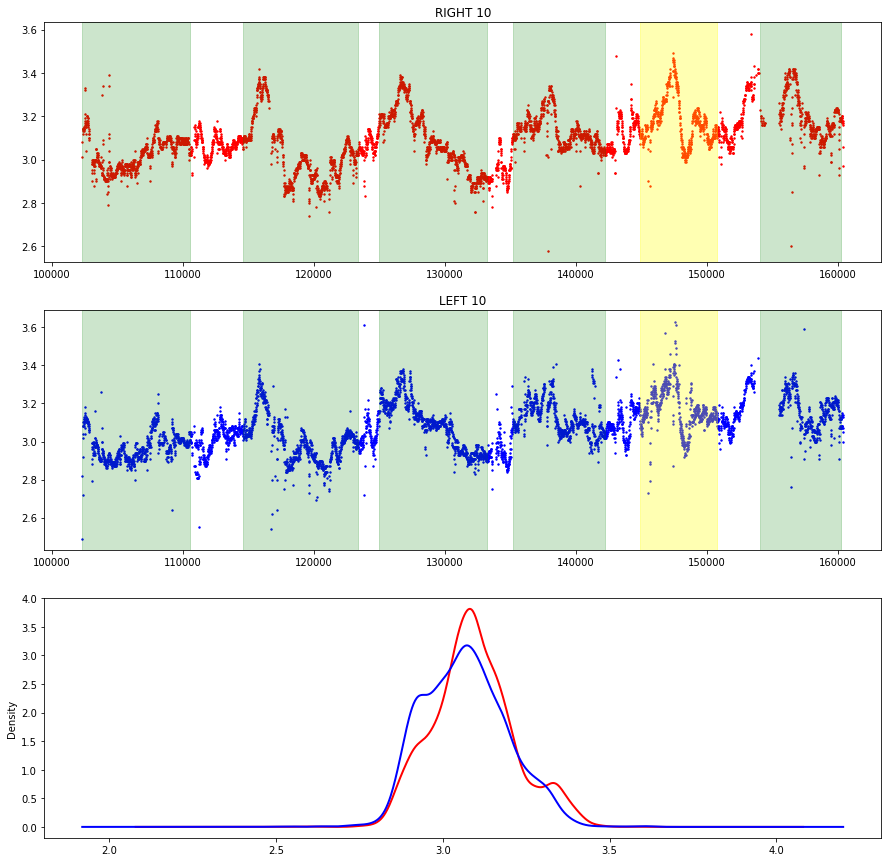

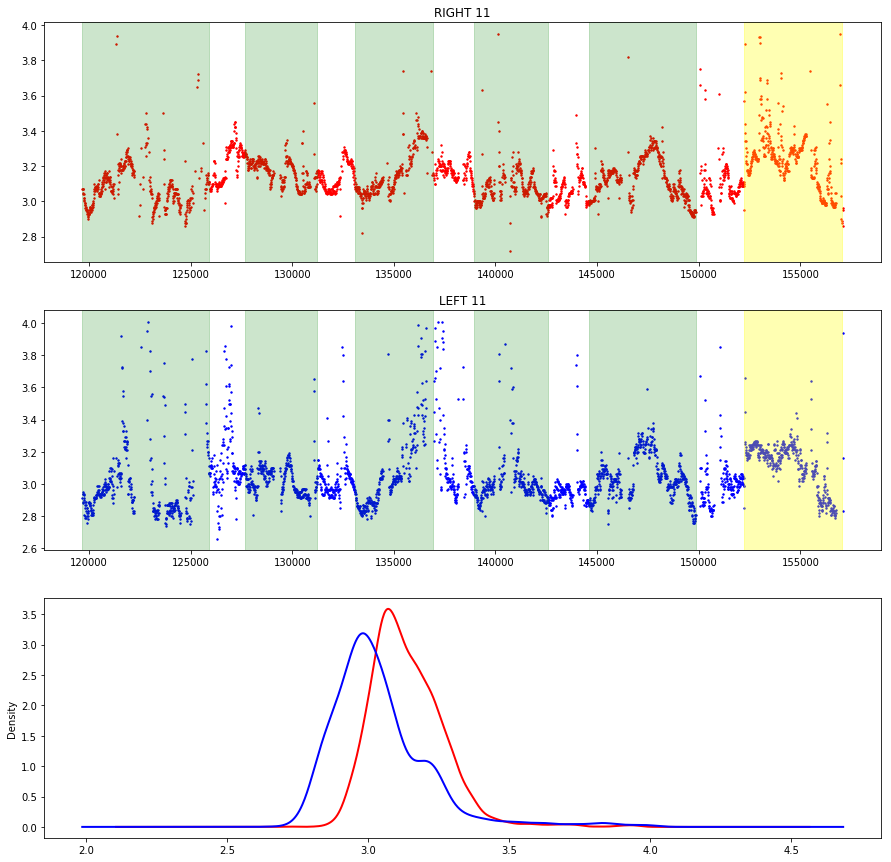

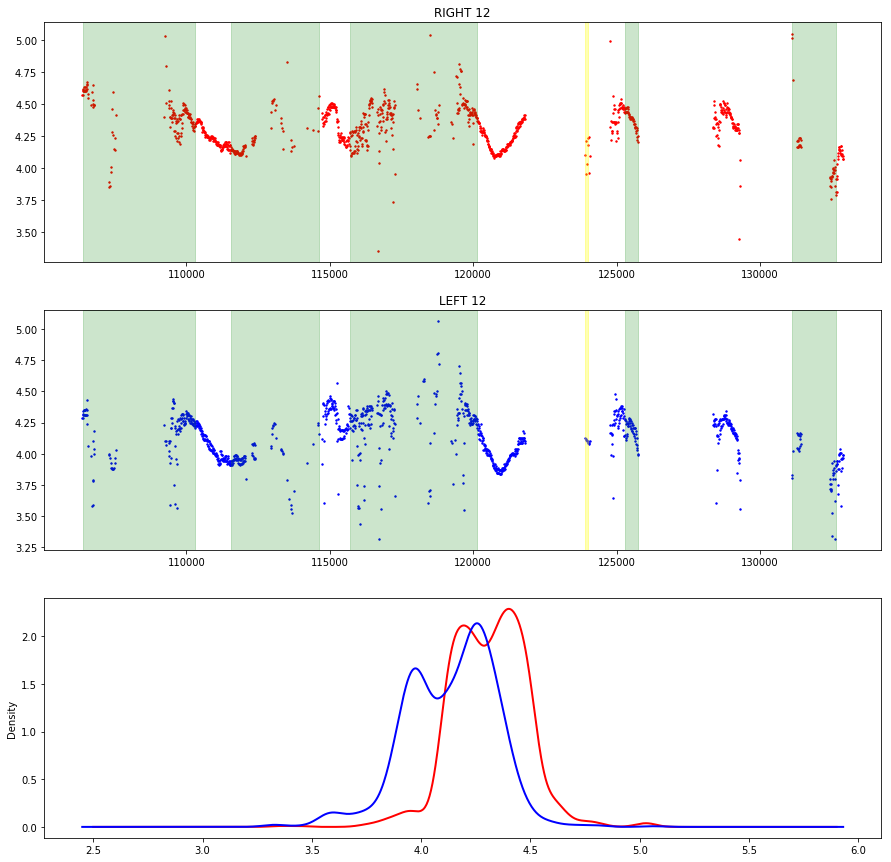

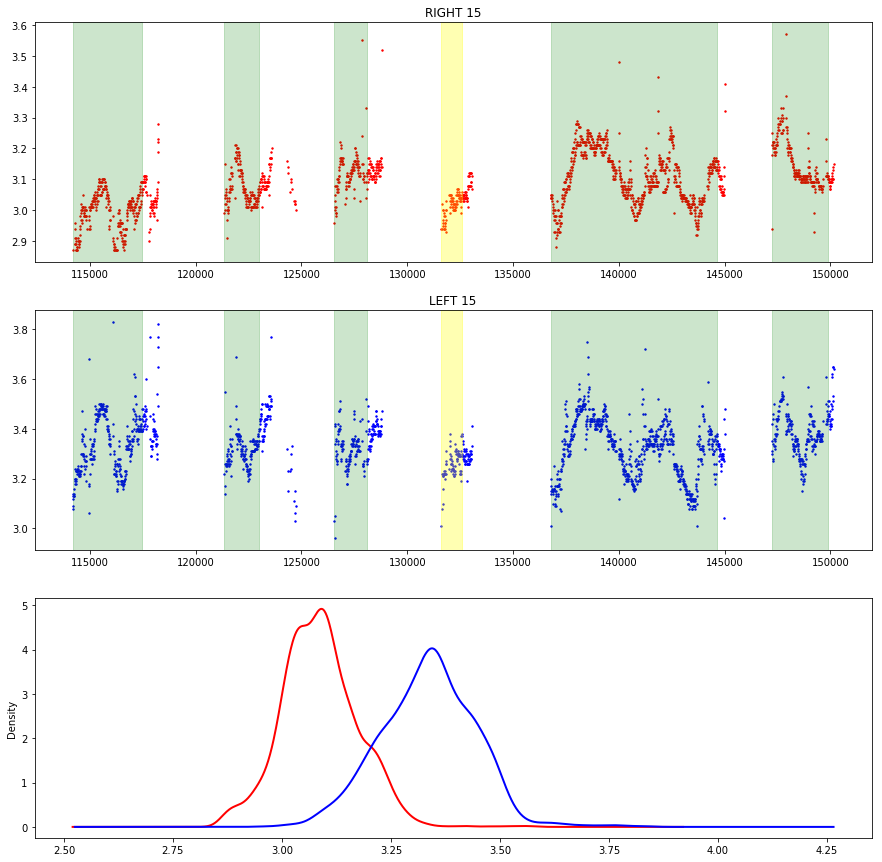

In [504]:
annot_subs = extractMinSubjectSet(annotations_in_temp)
eye_subs = extractMinSubjectSet(tobii_in_temp)
subjects = [s for s in eye_subs if s in annot_subs]
subjects.sort()

# Quelli che son belli da vedere
#subjects = [4, 5, 7, 8, 10, 11, 13, 14, 15, 18, 21, 22, 25]

column_names = [
        'subject','duration','card_class','show_order',
        'fix_freq','sacc_freq',
        'pupil_diam_right_mean','pupil_diam_right_std','pupil_diam_right_min','pupil_diam_right_max',
        'pupil_diam_left_mean','pupil_diam_left_std','pupil_diam_left_min','pupil_diam_left_max',
        'sre_fix_freq','sre_sacc_freq',
        'sre_pupil_diam_right_mean','sre_pupil_diam_right_std',
        'sre_pupil_diam_right_min','sre_pupil_diam_right_max',
        'sre_pupil_diam_left_mean','sre_pupil_diam_left_std',
        'sre_pupil_diam_left_min','sre_pupil_diam_left_max',
        'srl_fix_freq','srl_sacc_freq',
        'srl_pupil_diam_right_mean','srl_pupil_diam_right_std',
        'srl_pupil_diam_right_min','srl_pupil_diam_right_max',
        'srl_pupil_diam_left_mean','srl_pupil_diam_left_std',
        'srl_pupil_diam_left_min','srl_pupil_diam_left_max',
        'label'
    ]

short_response_dur = 1500
    
features = pd.DataFrame(columns=column_names)
card_names = ['unicorn', 'pepper', 'minion', 'pig', 'hedge', 'aliens']


for sub in subjects:
    eye_df, annot_dfs, baseline, overall_eye_df, cards_eye_dfs, cards_eye_early_dfs, cards_eye_late_dfs = \
                                                                        loadTimeSeries(sub, card_names)
    subject_card = getSubjectCard(sub, subject_cards_file)   
    mf = SubjectMagicFeatures(sub, subject_card,
                              annot_dfs,
                              cards_eye_dfs, cards_eye_early_dfs, cards_eye_late_dfs,
                              short_response_dur,
                              cols=column_names,
                              refer_to_baseline=True,
                              baseline=baseline,
                              refer_method='sub'
                             )
                             
    
    features = features.append(mf.getDataFrame(), ignore_index=True)
    figure = plotPupilDilationTimeSeries(sub, card_names, overall_eye_df, cards_eye_dfs)
    figure.savefig(figures_out.format(sub))


encoder = LabelEncoder()
encoder.fit(features['card_class'])
features['card_class_enc'] = encoder.transform(features['card_class'])

features.to_csv(features_baseline_sub_out, columns=column_names, sep='\t', index=False)
features
